### Loading Word2Vec Vectors

Word2Vec has the following parameters to follow:
<br>**size**: The number of dimensions of the embeddings and the default is 100.
<br>**window**: The maximum distance between a target word and words around the target word. The default window is 5.
<br>**min_count**: The minimum count of words to consider when training the model; words with occurrence less than this count will be ignored. The default for min_count is 5.
<br>**workers**: The number of partitions during training and the default workers is 3.
<br>**sg**: The training algorithm, either CBOW(0) or skip gram(1). The default training algorithm is CBOW.

<br> In our case, skipgram makes for sense

In [1]:
from gensim.models import Word2Vec, KeyedVectors
reloaded_word_vectors = KeyedVectors.load('vectors.kv')
print(reloaded_word_vectors.vectors)
embedding_matrix = reloaded_word_vectors.vectors.shape
print("Shape of embedding matrix:", embedding_matrix)


[[ 0.2126195   0.09919802  0.09328116 ... -0.09409698  0.17036866
   0.16593924]
 [ 0.05242195  0.648013    0.09244718 ...  0.32488975 -0.09047867
   0.05598368]
 [ 0.22919777  0.08127069 -0.27456412 ...  0.21367386 -0.06071062
   0.03780193]
 ...
 [ 0.4234368   0.55341655 -0.03553935 ... -0.26094872  0.1420558
   0.07539213]
 [ 0.12630396  0.5462421  -0.1951777  ... -0.6091752  -0.2604661
   0.8378617 ]
 [ 0.40905178  0.26061758  0.6039824  ... -0.03293396  0.0371629
   0.35710058]]
Shape of embedding matrix: (6062, 100)


## Training LSTM Model

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
from keras.layers import Embedding
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from datasets import load_dataset, Dataset
import pandas as pd


In [3]:
dataset = load_dataset(
    'csv', data_files="data/cleaned_labelled_tweets.csv", split='train')
dataset = dataset.train_test_split(test_size=0.2, shuffle=True, seed=1)


Using custom data configuration default-b7a65762879a719a
Reusing dataset csv (C:\Users\wisel\.cache\huggingface\datasets\csv\default-b7a65762879a719a\0.0.0\6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e)
Loading cached split indices for dataset at C:\Users\wisel\.cache\huggingface\datasets\csv\default-b7a65762879a719a\0.0.0\6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e\cache-5dbae5a4200bc6c7.arrow and C:\Users\wisel\.cache\huggingface\datasets\csv\default-b7a65762879a719a\0.0.0\6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e\cache-367f7d3919bf7913.arrow


In [4]:
# Load training and test dataset from cleaned and split data
train_data = pd.read_csv('data/train_data.csv')
test_data = pd.read_csv('data/test_data.csv')
# Relabel the sentiment value to [0,1] where 0 = neg and 1 = pos
train_data['label'] = train_data['label'].replace(-1, 0)
test_data['label'] = test_data['label'].replace(-1, 0)
# Transform dataset from pandas to dataset for consistency
train_df = Dataset.from_pandas(train_data)
test_df = Dataset.from_pandas(test_data)
# Split into training and validation dataset
trainval_df = train_df.train_test_split(test_size=0.2)
trainval_df, test_df


Parameter 'generator'=Generator(PCG64) of the transform datasets.arrow_dataset.Dataset.train_test_split couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


(DatasetDict({
     train: Dataset({
         features: ['text', 'label'],
         num_rows: 3705
     })
     test: Dataset({
         features: ['text', 'label'],
         num_rows: 927
     })
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1159
 }))

In [5]:
# Specify hyperparameters
vocab_size = embedding_matrix[0]
mxlen = 50
nb_classes = 2

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(trainval_df['train']['text'])
sequences_train = tokenizer.texts_to_sequences(trainval_df['train']['text'])
sequences_test = tokenizer.texts_to_sequences(test_df['text'])
sequences_val = tokenizer.texts_to_sequences(trainval_df['test']['text'])


In [6]:
word_index = reloaded_word_vectors.key_to_index
for i in word_index:  # to add 1 to the indexes given by Word2Vec as index 0 is reserved for padding
    if word_index['@stock'] < 2:
        word_index[i] += 1
    else:
        word_index['@stock'] = 1
        break

print('Found %s unique tokens.' % len(reloaded_word_vectors.key_to_index))
res = [(key, val) for key, val in word_index.items()]
print('Top few parts of token dict', res[:5])

# Pad vectors to same length
x_train = sequence.pad_sequences(sequences_train, maxlen=mxlen)
x_test = sequence.pad_sequences(sequences_test, maxlen=mxlen)
x_val = sequence.pad_sequences(sequences_val, maxlen=mxlen)


Found 6062 unique tokens.
Top few parts of token dict [('@stock', 1), ('@number', 2), ('http', 3), ('@user', 4), ('to', 5)]


In [7]:
# Transform sentiment value into categorical classes
y_train = np_utils.to_categorical(trainval_df['train']['label'], nb_classes)
y_test = np_utils.to_categorical(test_df['label'], nb_classes)
y_val = np_utils.to_categorical(trainval_df['test']['label'], nb_classes)


In [8]:
batch_size = 32
nb_epoch = 20

embedding_layer = Embedding(reloaded_word_vectors.vectors.shape[0],
                            reloaded_word_vectors.vectors.shape[1],
                            weights=[reloaded_word_vectors.vectors],
                            trainable=False)


In [9]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(128, recurrent_dropout=0.5, dropout=0.5))
model.add(Dense(nb_classes))
model.add(Activation('sigmoid'))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])
model.save("LSTM Model")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         606200    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
_________________________________________________________________
activation (Activation)      (None, 2)                 0         
Total params: 723,706
Trainable params: 117,506
Non-trainable params: 606,200
_________________________________________________________________
INFO:tensorflow:Assets written to: LSTM Model\assets


In [10]:
rnn = model.fit(x_train, y_train, epochs=nb_epoch, batch_size=batch_size,
                shuffle=True, validation_data=(x_val, y_val))


Epoch 1/20
116/116 [==============================] - 13s 91ms/step - loss: 0.6521 - accuracy: 0.6308 - val_loss: 0.6210 - val_accuracy: 0.6710
Epoch 2/20
116/116 [==============================] - 10s 87ms/step - loss: 0.6275 - accuracy: 0.6543 - val_loss: 0.6136 - val_accuracy: 0.6936
Epoch 3/20
116/116 [==============================] - 10s 86ms/step - loss: 0.6163 - accuracy: 0.6694 - val_loss: 0.5951 - val_accuracy: 0.7012
Epoch 4/20
116/116 [==============================] - 10s 88ms/step - loss: 0.6043 - accuracy: 0.6804 - val_loss: 0.5891 - val_accuracy: 0.7163
Epoch 5/20
116/116 [==============================] - 10s 87ms/step - loss: 0.5929 - accuracy: 0.6815 - val_loss: 0.5775 - val_accuracy: 0.7120
Epoch 6/20
116/116 [==============================] - 10s 88ms/step - loss: 0.5826 - accuracy: 0.6883 - val_loss: 0.5754 - val_accuracy: 0.6926
Epoch 7/20
116/116 [==============================] - 10s 89ms/step - loss: 0.5721 - accuracy: 0.7047 - val_loss: 0.5556 - val_accuracy:

In [11]:
score = model.evaluate(x_val, y_val)
print("Val Loss: %.2f%%" % (score[0]*100))
print("Val Accuracy: %.2f%%" % (score[1]*100))
score_2 = model.evaluate(x_test, y_test)
print("Test Loss: %.2f%%" % (score_2[0]*100))
print("Test Accuracy: %.2f%%" % (score_2[1]*100))


29/29 [==============================] - 1s 23ms/step - loss: 0.4984 - accuracy: 0.7627
Val Loss: 49.84%
Val Accuracy: 76.27%
37/37 [==============================] - 1s 14ms/step - loss: 0.5190 - accuracy: 0.7446
Test Loss: 51.90%
Test Accuracy: 74.46%


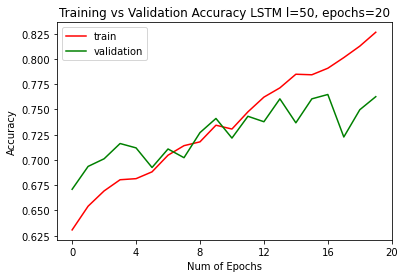

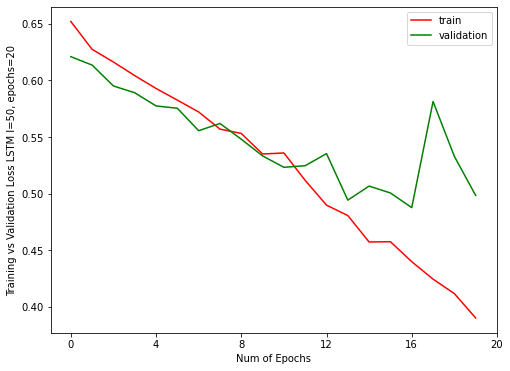

In [12]:
import matplotlib.pylab as plt
import numpy as np

plt.figure(0)
plt.plot(rnn.history['accuracy'], 'r')
plt.plot(rnn.history['val_accuracy'], 'g')
plt.xticks(np.arange(0, nb_epoch+1, nb_epoch/5))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
# for max length = 10 and 20 epochs
plt.title("Training vs Validation Accuracy LSTM l=50, epochs=20")
plt.legend(['train', 'validation'])

plt.figure(1)
plt.plot(rnn.history['loss'], 'r')
plt.plot(rnn.history['val_loss'], 'g')
plt.xticks(np.arange(0, nb_epoch+1, nb_epoch/5))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
# for max length = 10 and 20 epochs
plt.ylabel("Training vs Validation Loss LSTM l=50, epochs=20")
plt.legend(['train', 'validation'])
plt.show()


### Evaluating Model

In [13]:
# Check data
y_pred = model.predict(x_test)
# Convert Y_Test into 1D array
yy_true = [np.argmax(i) for i in y_test]
yy_scores = [np.argmax(i) for i in y_pred]

test_df = test_data
test_df['pred'] = yy_scores
test_df


,text,label,pred
0,green weekly triangle on @stock scaling at @nu...,0,0
1,ak corrected me @stock largest watch list gain...,1,1
2,@stock come on give it up,0,1
3,would be healthy and desirable for to eventual...,1,1
4,office owners with long term stable leases hop...,1,1
...,...,...,...
1154,the senior housing industry was facing financi...,0,0
1155,@stock if it goes to around @number i ll go short,0,0
1156,easy look at last @number yrs annual income data,1,1
1157,market wrap video additions to watch ist inclu...,1,1


In [14]:
# Reporting Scores
from sklearn.metrics import classification_report, confusion_matrix
target_names = ['Neg', 'Positive']
print(classification_report(test_df['label'],
      test_df['pred'], target_names=target_names))


              precision    recall  f1-score   support

         Neg       0.63      0.60      0.62       396
    Positive       0.80      0.82      0.81       763

    accuracy                           0.74      1159
   macro avg       0.72      0.71      0.71      1159
weighted avg       0.74      0.74      0.74      1159

